Replicate [Dynamic Return Dependencies Across Industries: A Machine Learning Approach](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3120110&download=yes) by David Rapach, Jack Strauss, Jun Tu and Guofu Zhou.

1) Use Keras NN classification instead of linear regression

2) Add additional variables, 3 and 12-month MA, interest rate change, yield curve, Mkt-RF, seasonal dummy variables. With cross-validation and regularization we hope to do that without overfitting and possibly produce a better result.


 

In [1]:
import os
import sys
import warnings
import numpy as np
np.random.seed(1764)
import pandas as pd

import time 
import datetime
import copy
import random
random.seed(1764)
from itertools import product

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy numpy warnings

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, mean_squared_error, explained_variance_score, r2_score
from sklearn.linear_model import LinearRegression, Lasso, lasso_path, lars_path, LassoLarsIC
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.stats import chisquare

import tensorflow as tf
tf.set_random_seed(1764)
print(tf.__version__)
# confirm GPU is in use
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Input
from keras.models import Model

from keras.layers.recurrent import LSTM, GRU
from keras.regularizers import l1
from keras.models import Sequential
from keras.models import load_model
    
import ffn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import plotly as py
# print (py.__version__) # requires version >= 1.9.0
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.figure_factory as ff

init_notebook_mode(connected=True)



1.8.0
[[22. 28.]
 [49. 64.]]


Using TensorFlow backend.


In [2]:
print("Loading data...")
data = pd.read_csv("30_Industry_Portfolios.csv")
data = data.set_index('yyyymm')
industries = list(data.columns)
# map industry names to col nums
ind_reverse_dict = dict([(industries[i], i) for i in range(len(industries))])

rfdata = pd.read_csv("F-F_Research_Data_Factors.csv")
rfdata = rfdata.set_index('yyyymm')
data['rf'] = rfdata['RF']

# subtract risk-free rate
# create a response variable led by 1 period to predict
for ind in industries:
    data[ind] = data[ind] - data['rf']

#for ind in industries:
#    data[ind+".3m"] = pd.rolling_mean(data[ind],3)
    
#for ind in industries:
#    data[ind+".6m"] = pd.rolling_mean(data[ind],6)

#for ind in industries:
#    data[ind+".12m"] = pd.rolling_mean(data[ind],12)
    
for ind in industries:
    data[ind+".lead"] = data[ind].shift(-1)

data = data.loc[data.index[data.index > 195911]]
data = data.drop(columns=['rf'])    
data = data.dropna(axis=0, how='any')

nresponses = len(industries)
npredictors = data.shape[1]-nresponses

predictors = list(data.columns[:npredictors])
predictor_reverse_dict = dict([(predictors[i], i) for i in range(len(predictors))])

responses = list(data.columns[-nresponses:])
response_reverse_dict = dict([(responses[i], i) for i in range(len(responses))])

print(data.shape)

data[['Food', 'Food.lead']]


Loading data...
(697, 60)


,Food,Food.lead
yyyymm,,
195912,2.01,-4.49
196001,-4.49,3.35
196002,3.35,-1.67
196003,-1.67,1.17
196004,1.17,8.20
196005,8.20,5.39
196006,5.39,-2.11
196007,-2.11,4.57
196008,4.57,-3.88


In [3]:
# exclude 2017 and later to tie to paper
data = data.loc[data.index[data.index < 201701]]
data = data.loc[data.index[data.index > 195911]]
data


,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm.lead,Servs.lead,BusEq.lead,Paper.lead,Trans.lead,Whlsl.lead,Rtail.lead,Meals.lead,Fin.lead,Other.lead
yyyymm,,,,,,,,,,,,,,,,,,,,,
195912,2.01,0.35,-3.02,1.64,7.29,0.67,1.87,-1.97,3.08,0.74,...,0.62,-6.18,-7.93,-9.41,-4.31,-5.33,-6.09,-10.08,-4.68,-3.98
196001,-4.49,-5.71,-2.05,1.21,-5.47,-7.84,-8.53,-6.68,-10.03,-4.77,...,8.07,9.13,5.09,3.00,-0.94,1.42,4.00,1.81,-0.98,6.32
196002,3.35,-2.14,2.27,4.23,2.39,9.31,1.44,-0.02,-0.74,0.32,...,-0.21,-0.31,3.34,-2.43,-4.99,-1.37,-0.13,-3.88,0.05,-2.43
196003,-1.67,-2.94,-0.18,-0.65,2.18,-0.56,-2.59,1.26,-2.75,-6.79,...,-1.24,7.14,1.77,0.41,-2.13,0.45,-0.53,8.86,-0.64,0.55
196004,1.17,-2.16,1.35,6.46,-1.17,-1.27,0.21,1.49,-5.53,-1.10,...,3.05,-1.75,11.90,2.85,0.90,1.65,3.11,0.80,-0.45,1.02
196005,8.20,-0.52,2.44,7.28,11.67,7.74,1.74,13.50,3.40,2.10,...,-0.58,-8.07,2.39,3.50,2.17,5.96,3.41,1.03,3.72,6.41
196006,5.39,0.47,4.73,2.24,0.02,6.38,-1.59,-0.40,0.45,4.04,...,-0.03,2.84,-2.02,-4.10,-3.11,-6.16,-2.99,-1.25,0.09,-5.95
196007,-2.11,-0.79,4.60,-4.72,0.23,-0.60,-1.10,-3.99,-6.80,-3.14,...,6.94,5.69,2.71,1.18,1.98,4.51,2.85,2.05,3.47,3.48
196008,4.57,3.24,5.20,7.16,3.63,5.09,3.34,2.29,1.17,-0.84,...,-6.07,-3.53,-7.61,-7.37,-7.07,-8.44,-8.57,-1.90,-5.78,-4.21


In [4]:
data.to_csv("data.csv")
desc = data.describe()
desc
# min, max line up with Table 1

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm.lead,Servs.lead,BusEq.lead,Paper.lead,Trans.lead,Whlsl.lead,Rtail.lead,Meals.lead,Fin.lead,Other.lead
count,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,...,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000
mean,0.690715,0.710613,0.982321,0.701708,0.528277,0.554190,0.669460,0.650905,0.519781,0.667416,...,0.520847,0.694234,0.584175,0.511241,0.582088,0.625562,0.662219,0.702730,0.609810,0.385620
std,4.339811,5.090215,6.061582,7.180918,5.809314,4.759874,6.386027,4.928072,5.518477,7.022552,...,4.628520,6.527984,6.738979,5.055314,5.739306,5.605317,5.349341,6.104515,5.411766,5.815446
min,-18.150000,-20.190000,-25.320000,-33.400000,-26.560000,-22.240000,-31.500000,-21.060000,-28.600000,-33.110000,...,-16.440000,-28.670000,-32.070000,-27.740000,-28.500000,-29.250000,-29.740000,-31.890000,-22.530000,-28.090000
25%,-1.640000,-2.100000,-2.780000,-3.490000,-2.690000,-2.110000,-2.810000,-2.240000,-2.800000,-3.200000,...,-2.110000,-3.090000,-3.290000,-2.430000,-2.780000,-2.570000,-2.430000,-2.940000,-2.420000,-2.990000
50%,0.740000,0.710000,1.280000,0.890000,0.510000,0.750000,0.690000,0.750000,0.670000,0.630000,...,0.610000,0.970000,0.560000,0.690000,0.860000,0.940000,0.470000,1.030000,0.820000,0.470000
75%,3.120000,3.660000,4.640000,5.310000,3.720000,3.550000,4.310000,3.560000,3.760000,4.490000,...,3.360000,4.290000,4.590000,3.460000,4.060000,3.880000,4.000000,4.330000,4.000000,4.200000
max,19.890000,25.510000,32.380000,34.520000,33.130000,18.220000,31.790000,29.010000,21.680000,59.030000,...,21.220000,23.380000,24.660000,21.000000,18.500000,17.530000,26.490000,27.380000,20.590000,19.960000


In [5]:
# annualized returns don't match Table 1, oddly
# geometric mean, annualized
pd.DataFrame((np.prod(data/100 + 1)**(12.0/len(data))-1)[:30], columns=['Mean Ann. Return'])

,Mean Ann. Return
Food,0.074020
Beer,0.072005
Smoke,0.100147
Games,0.054031
Books,0.043953
Hshld,0.054098
Clths,0.057170
Hlth,0.065463
Chems,0.044917
Txtls,0.051888


In [6]:
# try this way, arithmetic mean then annualize (not very correct)
#print(pd.DataFrame(((desc.loc['mean']/100+1)**12-1)[:30]))
#nope

# same
pd.DataFrame(((1 + np.mean(data, axis=0)/100)**12 -1)[:30], columns=['Mean Ann. Return'])

,Mean Ann. Return
Food,0.086108
Beer,0.088687
Smoke,0.124460
Games,0.087532
Books,0.065268
Hshld,0.068568
Clths,0.083360
Hlth,0.080966
Chems,0.064188
Txtls,0.083096


In [7]:
#annualized volatility 
pd.DataFrame((desc.loc['std']*np.sqrt(12))[:30].round(2))
# lines up with table 1

,std
Food,15.03
Beer,17.63
Smoke,21.00
Games,24.88
Books,20.12
Hshld,16.49
Clths,22.12
Hlth,17.07
Chems,19.12
Txtls,24.33


In [8]:
# skip last row to better match published r-squared
# looks like they forecast actuals 1960-2016 using 1959m12 to 2016m11
# not exact matches to Table 2 R-squared but almost within rounding error 
X = data.values[:-1,:npredictors]
Y = data.values[:-1,-nresponses:]
nrows = X.shape[0]
X.shape

(684, 30)

In [9]:
# convert Ys to 3 classes
# long = 1
# short = 2
# neither = 0
ISLONG=1
ISSHORT=2
ISFLAT=0

Y_sortindex = np.argsort(Y)
print(Y[0])
# sorted position
print(Y_sortindex[0]) 
# sorted array
print(Y[0,Y_sortindex[0]])
# initialize class to 0
Y_class=np.zeros_like(Y)
for row in range(Y_class.shape[0]):
    # if index in last 6, long
    longlist = Y_sortindex[row,-6:]
    Y_class[row, longlist]=ISLONG
    # if index is in first 6, short
    shortlist = Y_sortindex[row,:6]
    Y_class[row, shortlist]=ISSHORT
    
print(Y_class[0])
print([Y[0,i] for i in range(30) if Y_class[0,i]==1])
print([Y[0,i] for i in range(30) if Y_class[0,i]==2])
print(Y_class.shape)
print(X.shape)


[ -4.49  -5.71  -2.05   1.21  -5.47  -7.84  -8.53  -6.68 -10.03  -4.77
  -6.67  -9.38  -4.42 -12.3  -11.71  -5.03  -3.81  -7.91  -7.82  -2.4
   0.62  -6.18  -7.93  -9.41  -4.31  -5.33  -6.09 -10.08  -4.68  -3.98]
[13 14 27  8 23 11  6 22 17  5 18  7 10 21 26  1  4 25 15  9 28  0 12 24
 29 16 19  2 20  3]
[-12.3  -11.71 -10.08 -10.03  -9.41  -9.38  -8.53  -7.93  -7.91  -7.84
  -7.82  -6.68  -6.67  -6.18  -6.09  -5.71  -5.47  -5.33  -5.03  -4.77
  -4.68  -4.49  -4.42  -4.31  -3.98  -3.81  -2.4   -2.05   0.62   1.21]
[0. 0. 1. 1. 0. 0. 0. 0. 2. 0. 0. 2. 0. 2. 2. 0. 1. 0. 0. 1. 1. 0. 0. 2.
 0. 0. 0. 2. 0. 1.]
[-2.05, 1.21, -3.81, -2.4, 0.6199999999999999, -3.98]
[-10.03, -9.38, -12.3, -11.71, -9.41, -10.08]
(684, 30)
(684, 30)


In [10]:
# use all predictors - higher in-sample R-squared
coef_dict_all = []
for _ in responses:
    coef_dict_all.append(range(len(predictors)))


In [11]:
# first iteration will train up to including 196911
# will use 196912 to predict 197001
# 1970101 will be first month of performance to use
# train on first 121 months up to 196912 (0:120), put first prediction in P[121] (122nd row)
# first month of performance will be 197002
FIRST_TRAIN_MONTHS = 121
FIRST_PREDICT_MONTH = FIRST_TRAIN_MONTHS # This is stupid but keeps my head straight

print(X[FIRST_TRAIN_MONTHS])
print(data.iloc[FIRST_TRAIN_MONTHS][:30])

[ -3.34  -1.95  -7.59  -7.76 -12.05  -7.5   -5.69  -7.71  -7.37  -5.26
  -9.84  -6.31  -7.15  -6.89  -9.35 -12.49  -2.34  -0.77 -12.16  -4.83
  -3.16 -11.17  -9.73  -8.89  -8.17  -8.28  -6.31 -13.12  -9.78  -6.2 ]
Food     -3.34
Beer     -1.95
Smoke    -7.59
Games    -7.76
Books   -12.05
Hshld    -7.50
Clths    -5.69
Hlth     -7.71
Chems    -7.37
Txtls    -5.26
Cnstr    -9.84
Steel    -6.31
FabPr    -7.15
ElcEq    -6.89
Autos    -9.35
Carry   -12.49
Mines    -2.34
Coal     -0.77
Oil     -12.16
Util     -4.83
Telcm    -3.16
Servs   -11.17
BusEq    -9.73
Paper    -8.89
Trans    -8.17
Whlsl    -8.28
Rtail    -6.31
Meals   -13.12
Fin      -9.78
Other    -6.20
Name: 197001, dtype: float64


In [20]:

class BacktestModel():
    
    def __init__(self, 
                 X, # predictors
                 Y, # responses
                 model=None, # model that supports fit(X,Y), predict(X) , predicts an entire row,
                 create_model=None, # or create_model which returns a model (needed for 'timestep' but slows down so pass model if dynamic not needed)
                 coef_dict_param="all", # mapping of predictors to responses ("all", "timestep", or a list of lists)
                 startindex=FIRST_TRAIN_MONTHS,
                 scaler=None,
                 fit_missing=None):
        
        self.Xrows, self.Xcols = X.shape
        self.Yrows, self.Ycols = Y.shape
        
        if self.Xrows != self.Yrows:
            raise(ValueError, "Shapes differ: X %s, Y %s" % (str(X.shape), str(Y.shape)))            
            
        self.X = X
        self.Y = Y
        self.Xscale = X.copy()
        self.Yscale = Y.copy()

        if scaler:
            # MinMaxScaler: each row (min->0, max->1) 
            # StandardScaler: each row (mean->0, SD->1)            
            # transpose, scale, transpose back because scales by columns
            print("scaler: %s " %str(scaler))
            self.Xscale = scaler().fit_transform(Xscale.transpose()).transpose()
            self.Yscale = scaler().fit_transform(Yscale.transpose()).transpose()
        
        self.model = model
        self.create_model = create_model
        self.coef_dict_param = coef_dict_param
        self.startindex = startindex
        self.fit_missing = fit_missing

    def fit_predict(self, ntrain, npredict=1, verbose=False):
        """for backtest, train model using Y v. X 
        train on first ntrain rows. if ntrain=121, fit 0:120
        predict following npredict rows 
        if npredict=1, predict row 121
        if npredict=12, predict rows 121-132
        """
        
        # fit first ntrain rows
        X_fit = self.Xscale[:ntrain]  # e.g. 0:120
        Y_fit = self.Yscale[:ntrain]
        # predict npredict rows
        X_predict = self.Xscale[ntrain:ntrain+npredict] # 121-122
        X_predict = X_predict.reshape(npredict,self.Xcols)
       
        # if no coef_dict select predictors into coef_dict
        if self.coef_dict_param == "timestep":
            msg = "Performing subset selection"
            coef_dict = subset_selection(X_fit, Y_fit, LassoLarsIC(criterion='aic'))
        # if coef_dict == "all" use all predictors for each response        
        elif self.coef_dict_param == 'all':
            msg = "Using all predictors"
            coef_dict = [range(self.Xcols) for _ in range(self.ycols)]
        else: # should check valid dict
            msg = "Using coef_dict predictors"
            coef_dict = self.coef_dict_param
        if verbose: 
            print(msg)

        if self.create_model:
            self.model = PredictWrapper(self.create_model, coef_dict, fit_missing=self.fit_missing)
            
        self.model.fit(X_fit, Y_fit, verbose=verbose)
        return self.model.predict(X_predict, verbose=verbose)

    # predict all months
    # initial train_months = 120 -> train first model on 120 rows
    # first prediction will be in P[120] (121st row)
    # step = 6 -> predict following 6 rows, then step forward 6 months at a time
    # initialize predictions matrix self.P
    
    # use either step or folds
    # step, do range(self.startindex, nrows, step)
    # folds, at each fold train 0:startfold, predict startfold+1:endfold
    # store only out-of-sample predictions in P, calc out-of-sample MSE
    
    # using a step > 1 or folds is quicker, for quicker xval, or to speed up by not estimating model at each timestep

    def gen_predictions(self,
                        step=1, 
                        splits=None,
                        verbose=False):

        self.P_L = np.zeros((Y_class.shape[0],OUTPUT_DIM))
        self.P_S = np.zeros((Y_class.shape[0],OUTPUT_DIM))
        self.P_F = np.zeros((Y_class.shape[0],OUTPUT_DIM))
        self.P = np.zeros((Y_class.shape[0],OUTPUT_DIM))

        progress_i = 0
        self.nrows, self.ycols = Y.shape
        
        if splits:
            month_indexes = splits[:-1] # last index is nrows
        else:
            # create list of steps
            month_indexes = list(range(self.startindex, nrows, step))
        steps = [month_indexes[i+1]-month_indexes[i] for i in range(len(month_indexes)-1)]
        # last step -> end
        steps.append(self.nrows - month_indexes[-1])
        
        if verbose:
            print ("Steps: " + str(month_indexes))

        for month_index, forecast_rows in zip(month_indexes, steps):
            if verbose:
                print("Training on first %d rows (%d:%d), putting predictions in rows %s" % (month_index, 
                                                                                            0, month_index-1, 
                                                                                            str(range(month_index,month_index+forecast_rows))))
            longprobs, shortprobs, flatprobs = self.fit_predict(month_index, forecast_rows, verbose=False)

            first_pred_row = month_index
            for row_index in range(forecast_rows):
                self.P_L[first_pred_row + row_index] = longprobs[row_index]
                self.P_S[first_pred_row + row_index] = shortprobs[row_index]
                self.P_F[first_pred_row + row_index] = flatprobs[row_index]
                # do longprob - shortprob
                self.P[first_pred_row + row_index] = longprobs[row_index] - shortprobs[row_index]
            sys.stdout.write('.')
            progress_i += 1
            if progress_i % 80 == 0:
                print("")
                print("%s Still training step %d of %d" % (time.strftime("%H:%M:%S"), progress_i, len(month_indexes)))
            sys.stdout.flush()
        print("")
        

    def evaluate_predictions(self):
        
        # evaluate prediction (can move to separate function)
        msetemp = (self.P[self.startindex:]-self.Yscale[self.startindex:])**2
        #remove nans
        msetemp = msetemp[~np.isnan(msetemp)]
        mse = np.mean(msetemp)
        print("MSE across all predictions: %.4f" % mse)
        
        # force unpredicted ys to be nans, then remove nans
        vartemp = self.Yscale[self.startindex:] - self.P[self.startindex:] + self.P[self.startindex:]
        vartemp = vartemp[~np.isnan(vartemp)]
        y_variance = np.var(vartemp[self.startindex:])
        print("Variance: %.4f" % (y_variance))
        print("R-squared: %.4f" % (1- mse/y_variance))
        
        return(mse)

    def evaluate_quantiles(self, chart=False, verbose=False, Y=None):

        if Y is None: #kludgey override Y
            evalY = self.Y
        else:
            evalY = Y

        self.P_quantiles = np.zeros_like(self.P)
        self.Y_quantiles = np.zeros_like(evalY)
        
        # compute score for predicted quantiles vs. actual (expected) quantiles
        N_QUANTILES=5
        for row in range(self.startindex, self.P_quantiles.shape[0]):
            #print(self.P[row])
            self.P_quantiles[row] = pd.qcut(self.P[row], N_QUANTILES, range(N_QUANTILES))
            self.Y_quantiles[row] = pd.qcut(evalY[row], N_QUANTILES, range(N_QUANTILES))

        pred_quantiles = self.P_quantiles[self.startindex:]
        true_quantiles = self.Y_quantiles[self.startindex:]

        nrows, ncols = pred_quantiles.shape

        pred_quantiles = pred_quantiles.reshape(nrows*ncols)
        true_quantiles = true_quantiles.reshape(nrows*ncols) 
        
        nrows = nrows * ncols
        conf_mat = confusion_matrix(pred_quantiles, true_quantiles)
        if chart:
            fig, ax = plt.subplots(figsize=(10,10))
            sns.heatmap(conf_mat, annot=True, fmt='d')
            plt.ylabel('Actual')
            plt.xlabel('Predicted')
            plt.show()
            
        if verbose:
            print(chisquare(conf_mat))

        conf_mat_expected = np.array([[0.64, 0.16],[0.16, 0.04]])

        myscores = []
        for q in range(5):
            temp_pred = pred_quantiles == q
            temp_actual = true_quantiles == q
            conf_mat = confusion_matrix(temp_pred, temp_actual) / float(nrows)
            diff_mat = conf_mat - conf_mat_expected
            if verbose:
                print(conf_mat)
                print(diff_mat)
                print(chisquare(conf_mat.reshape(4)*nrows, conf_mat_expected.reshape(4)*nrows))
            # probably no valid statistical interpretation but 
            # average of improvement in true positive % and true negative %
            myscore = (diff_mat[0][0] + diff_mat[1][1])/2
            myscores.append(myscore)

        # average of my score for top and bottom quintiles
        finalscore = (myscores[0] + myscores[4])/2
        if verbose:
            print("Score: %f" % (finalscore))
            
        return finalscore

    def walkforward_xval (self, n_splits=5, verbose=False):
        """quick and dirty genreturns, with a step"""
        # generate k-folds
        kf = KFold(n_splits=n_splits)
        kf.get_n_splits(X)
        last_indexes = []
        for train_index, test_index in kf.split(X):
            # use test_index as last index to train
            last_index = test_index[-1] + 1
            last_indexes.append(last_index)
        print("%s Generate splits %s" % (time.strftime("%H:%M:%S"), str([i for i in last_indexes])))
        #override startindex
        self.startindex = last_indexes[0]
        return self.gen_predictions(splits=last_indexes, verbose=verbose)
    
    def gen_returns(self, port_returns_func, verbose=False):

        self.R = np.zeros(self.P.shape[0])
        first_pred_month=self.startindex
        
        indcount = [0] * self.ycols
        longcount = [0] * self.ycols
        shortcount = [0] * self.ycols
        
        for month_index in range(first_pred_month, nrows-1):
            return_month = month_index + 1
            port_return, long_indexes, short_indexes = port_returns_func(self.P[month_index], 
                                                                         self.X[return_month])
            self.R[return_month] = port_return
            
            for i in long_indexes:
                indcount[i] += 1
                longcount[i] += 1
            for i in short_indexes:
                indcount[i] += 1
                shortcount[i] += 1
                
        for i in range(len(responses)):
            print("%s: long %d times, short %d times, total %d times" % (predictors[i], 
                                                                         longcount[i], 
                                                                         shortcount[i], 
                                                                         indcount[i]))
        return self.R

    def report_returns(self, start_date='01/01/1970', freq='M'):

        first_pred_month=self.startindex        
        results = self.R[first_pred_month:]
        index = pd.date_range(start_date,periods=results.shape[0], freq=freq)
        perfdata = pd.DataFrame(results,index=index,columns=['Returns'])
        perfdata['Equity'] = 100 * np.cumprod(1 + results / 100)
        self.cumulative_return = perfdata['Equity']

        stats = perfdata['Equity'].calc_stats()
        
        retframe = pd.DataFrame([stats.stats.loc['start'],
                                 stats.stats.loc['end'],
                                 stats.stats.loc['cagr'],
                                 stats.stats.loc['yearly_vol'],
                                 stats.stats.loc['yearly_sharpe'],
                                 stats.stats.loc['max_drawdown'],
                                 ffn.core.calc_sortino_ratio(perfdata.Returns, rf=0, nperiods=564, annualize=False),
                                ],
                                index = ['start',
                                         'end',
                                         'cagr',
                                         'yearly_vol',
                                         'yearly_sharpe',
                                         'max_drawdown',
                                         'sortino',
                                        ],
                                columns=['Value'])   
        return retframe

In [13]:
NUMSTOCKS = 6 # top quintile (and bottom)

def calc_returns(prediction_row, return_row, numstocks=NUMSTOCKS, verbose=False):

    # ensure nan sorts to top for shorts
    short_sort_array = [999999 if np.isnan(x) else x for x in prediction_row]
    # pick bottom numstocks
    select_array = np.argsort(short_sort_array)
    short_indexes = select_array[:numstocks]

    # ensure nan sorts to bottom for longs
    long_sort_array = [-999999 if np.isnan(x) else x for x in prediction_row]
    # pick top numstocks
    select_array = np.argsort(long_sort_array)
    long_indexes = select_array[-numstocks:]
    
    if verbose:
        print("Longs: %s" %(str([(i,prediction_row[i]) for i in long_indexes])))
        print("Shorts: %s" %(str([(i,prediction_row[i]) for i in short_indexes])))

    # compute equal weighted long/short return
    return np.mean(return_row[long_indexes])/2 - np.mean(return_row[short_indexes])/2, long_indexes, short_indexes


In [14]:
start_date_int = data.index[FIRST_TRAIN_MONTHS]
start_year, start_month = start_date_int // 100, start_date_int % 100
start_date_str = "%02d/%02d/%d" % (start_month, 1, start_year)
start_date_str

'01/01/1970'

In [15]:
# use keras instead of sklearn MLPRegressor
# wrap keras model in a class 
# multioutput 30 predictions simultaneously to speed up 
# fit takes a list of response ys, predict returns a list of y_predict arrays
# no coef_dict
INPUT_DIM = X.shape[1]
NCLASSES=3
print(INPUT_DIM)
OUTPUT_DIM = len(responses) # 30
BATCH_SIZE = 64
EPOCHS=500

# 500 is arbitrary, which bugs me
# something one could do is backtest and walk-forward xval with an xval set
# leave 30 months out of training fold, train until error on those 30 months is minimized, eval on following fold
# the other thing that bugs me is higher epochs take longer and yield worse results, there's some 'regularization thruogh under-training' going on
# but stochastically will never train at same speed, so you can pick a model and it might need more or less training than 100 in production

class KerasBacktestModel(object):

    def __init__(self, 
                 n_hidden_layers = 2,
                 hidden_layer_size = 32,
                 reg_penalty = 0.0001,
                 dropout = 0.25,
                 epochs=EPOCHS,
                 verbose=True):
        
        self.epochs=epochs
        
        """initialize keras model"""
        
        main_input = Input(shape=(INPUT_DIM,),
                           dtype='float32', 
                           name='main_input')
        lastlayer=main_input
        
        for i in range(n_hidden_layers):
            if verbose:
                print("layer %d size %d, reg_penalty %.8f, dropout %.3f" % (i + 1, 
                                                                            hidden_layer_size, 
                                                                            reg_penalty, 
                                                                            dropout))
            lastlayer = Dense(units = hidden_layer_size, 
                              activation = 'relu',
                              kernel_initializer = keras.initializers.glorot_uniform(),
                              kernel_regularizer=keras.regularizers.l1(reg_penalty),
                              name = "Dense%02d" % i)(lastlayer)
            
            if dropout:
                lastlayer = Dropout(dropout, name = "Dropout%02d" % i)(lastlayer)
                
        outputs = []
        for i in range(OUTPUT_DIM):
            # OUTPUT_DIM outputs
            outputs.append(Dense(NCLASSES, 
                                 activation='softmax',
                                 name = "Output%02d" % (i+1))(lastlayer))
            
        self.model = Model(inputs=[main_input], outputs=outputs)
        if verbose:
            print(self.model.summary())
            
        self.model.compile(loss="categorical_crossentropy", 
                           optimizer="rmsprop", 
                           metrics=['accuracy'])
    
        
    def fit(self, X, Y, epochs=None, verbose=False):
        # convert Y to list of ys
        nrows, npreds = Y.shape
        Y_list = [keras.utils.to_categorical(Y[:,i], num_classes=NCLASSES) for i in range(OUTPUT_DIM)]

        if epochs:
            self.epochs = epochs
            
        fit = self.model.fit(X,
                             Y_list,
                             batch_size=BATCH_SIZE,
                             epochs=self.epochs,
                             verbose=False)
        #evaluate returns a list of overall loss, loss by column and then accuracy by column
        evaluate = self.model.evaluate(X, Y_list, batch_size=BATCH_SIZE, verbose=1)
        self.accuracy = np.mean(np.array(evaluate[-npreds:]))

        return fit
   
    def predict(self, X, verbose=False):
        """predict classes using X"""
        # convert list of ys to Y array
        nrows, npreds = X.shape
        y_list = self.model.predict(X)
        longprobs = np.zeros([nrows, OUTPUT_DIM])
        shortprobs = np.zeros([nrows, OUTPUT_DIM])
        flatprobs = np.zeros([nrows, OUTPUT_DIM])

        evaluate_array = self.model.evaluate(X, y_list, batch_size=BATCH_SIZE, verbose=1)
        self.accuracy = np.mean(np.array(evaluate_array[-npreds:]))
        
        for response in range(OUTPUT_DIM):
            for row in range(nrows):
                longprobs[row, response] = y_list[response][row, ISLONG]
                shortprobs[row, response] = y_list[response][row, ISSHORT]
                flatprobs[row, response] = y_list[response][row, ISFLAT]
                
        return longprobs, shortprobs, flatprobs

    def evaluate(self, X, Y):
        """predict classes using X"""
        # convert list of ys to Y array
        nrows, npreds = Y.shape
        Y_list = [keras.utils.to_categorical(Y[:,i], num_classes=NCLASSES) for i in range(OUTPUT_DIM)]
        evaluate_array = self.model.evaluate(X, Y_list, batch_size=BATCH_SIZE, verbose=False)
        self.accuracy = np.mean(np.array(evaluate_array[-npreds:]))
        
        return self.accuracy
     
    def save(self, modelname):
        self.model.save("%s.h5" % modelname)
        self.model.save_weights("%s_weights.h5" % modelname)


30


In [16]:

keras_model = KerasBacktestModel(n_hidden_layers = 0,
                                 reg_penalty = 0.0,
                                 verbose=True,
                                 epochs=2000)

backtestmodel = BacktestModel(X, Y_class, 
                              model=keras_model, 
                              coef_dict_param=coef_dict_all, 
                              startindex=FIRST_TRAIN_MONTHS)
print(backtestmodel.fit_predict(121, npredict=3, verbose=True))



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 30)           0                                            
__________________________________________________________________________________________________
Output01 (Dense)                (None, 3)            93          main_input[0][0]                 
__________________________________________________________________________________________________
Output02 (Dense)                (None, 3)            93          main_input[0][0]                 
__________________________________________________________________________________________________
Output03 (Dense)                (None, 3)            93          main_input[0][0]                 
__________________________________________________________________________________________________
Output04 (

In [17]:
keras_model.evaluate(X,Y_class)

0.49083820662913263

In [18]:
# run linear model,compare results
def create_keras_model(n_hidden_layers, layer_size, reg_penalty, verbose=False):
    return KerasBacktestModel(n_hidden_layers = n_hidden_layers,
                              hidden_layer_size = layer_size,
                              reg_penalty = reg_penalty,
                              epochs=500,
                              verbose=verbose)


In [21]:
MODELPREFIX = "NN"

n_hiddens = [1, 2, 3]
layer_sizes = [1, 2, 4]
reg_penalties = [0.0, 0.01, 1]
hyperparameter_combos = list(product(n_hiddens, layer_sizes, reg_penalties))

print("%s Running %d experiments" % (time.strftime("%H:%M:%S"), len(hyperparameter_combos)))
# should really just use a list and convert to dataframe
experiments = {}
sharpes = {}
quantile_scores = {}

for counter, param_list in enumerate(hyperparameter_combos):
    n_hidden_layers, layer_size, reg_penalty = param_list
    print("%s Running experiment %d of %d" % (time.strftime("%H:%M:%S"), counter+1, len(hyperparameter_combos)))
    key = (n_hidden_layers, layer_size, reg_penalty)
    print("%s n_hidden_layers = %d, hidden_layer_size = %d, reg_penalty = %.6f" % 
          (time.strftime("%H:%M:%S"), n_hidden_layers, layer_size, reg_penalty))
    
    experiment_model = BacktestModel(X, Y_class, 
                                     create_keras_model(n_hidden_layers,layer_size,reg_penalty), 
                                     coef_dict_param="all", 
                                     startindex=FIRST_TRAIN_MONTHS)
    experiment_model.walkforward_xval(n_splits=5)
    score = experiment_model.evaluate_predictions()
    experiments[key] = score
    quantile_score = experiment_model.evaluate_quantiles(chart=True, verbose=True, Y=Y)
    quantile_scores[key] = quantile_score

    experiment_model.gen_returns(calc_returns, verbose=False)
    retframe = experiment_model.report_returns(start_date=start_date_str, freq='M')
    sharpe = retframe.loc['yearly_sharpe']
    sharpes[key] = sharpe.values[0]
    
    print("%s Quantile score: %f" % (str(key), quantile_score))
    print("%s Sharpe: %f" % (str(key), sharpe))



14:56:37 Running 27 experiments
14:56:37 Running experiment 1 of 27
14:56:37 n_hidden_layers = 1, hidden_layer_size = 1, reg_penalty = 0.000000
14:56:38 Generate splits [137, 274, 411, 548, 684]
136/136 [==============================] - 0s 548us/step
.
MSE across all predictions: 1.0106
Variance: 0.6398
R-squared: -0.5795
Food: long 36 times, short 0 times, total 36 times
Beer: long 250 times, short 0 times, total 250 times
Smoke: long 189 times, short 0 times, total 189 times
Games: long 83 times, short 0 times, total 83 times
Books: long 64 times, short 0 times, total 64 times
Hshld: long 125 times, short 98 times, total 223 times
Clths: long 434 times, short 9 times, total 443 times
Hlth: long 416 times, short 0 times, total 416 times
Chems: long 0 times, short 288 times, total 288 times
Txtls: long 308 times, short 53 times, total 361 times
Cnstr: long 0 times, short 171 times, total 171 times
Steel: long 0 times, short 546 times, total 546 times
FabPr: long 0 times, short 99 time

16:19:36 Generate splits [137, 274, 411, 548, 684]
136/136 [==============================] - 0s 544us/step
.
MSE across all predictions: 1.0157
Variance: 0.6398
R-squared: -0.5876
Food: long 304 times, short 45 times, total 349 times
Beer: long 220 times, short 38 times, total 258 times
Smoke: long 319 times, short 46 times, total 365 times
Games: long 124 times, short 97 times, total 221 times
Books: long 44 times, short 0 times, total 44 times
Hshld: long 75 times, short 37 times, total 112 times
Clths: long 228 times, short 5 times, total 233 times
Hlth: long 408 times, short 3 times, total 411 times
Chems: long 0 times, short 254 times, total 254 times
Txtls: long 36 times, short 43 times, total 79 times
Cnstr: long 18 times, short 91 times, total 109 times
Steel: long 26 times, short 498 times, total 524 times
FabPr: long 15 times, short 130 times, total 145 times
ElcEq: long 28 times, short 0 times, total 28 times
Autos: long 74 times, short 195 times, total 269 times
Carry: lon

17:43:38 Generate splits [137, 274, 411, 548, 684]
136/136 [==============================] - 0s 555us/step
.
MSE across all predictions: 1.0046
Variance: 0.6398
R-squared: -0.5701
Food: long 0 times, short 3 times, total 3 times
Beer: long 248 times, short 0 times, total 248 times
Smoke: long 362 times, short 66 times, total 428 times
Games: long 247 times, short 44 times, total 291 times
Books: long 148 times, short 6 times, total 154 times
Hshld: long 110 times, short 49 times, total 159 times
Clths: long 350 times, short 2 times, total 352 times
Hlth: long 481 times, short 12 times, total 493 times
Chems: long 0 times, short 403 times, total 403 times
Txtls: long 51 times, short 0 times, total 51 times
Cnstr: long 0 times, short 124 times, total 124 times
Steel: long 0 times, short 509 times, total 509 times
FabPr: long 0 times, short 237 times, total 237 times
ElcEq: long 0 times, short 0 times, total 0 times
Autos: long 21 times, short 128 times, total 149 times
Carry: long 41 ti

19:29:39 Generate splits [137, 274, 411, 548, 684]
136/136 [==============================] - 0s 550us/step
.
MSE across all predictions: 1.0059
Variance: 0.6398
R-squared: -0.5721
Food: long 5 times, short 0 times, total 5 times
Beer: long 215 times, short 0 times, total 215 times
Smoke: long 104 times, short 15 times, total 119 times
Games: long 366 times, short 92 times, total 458 times
Books: long 266 times, short 61 times, total 327 times
Hshld: long 154 times, short 102 times, total 256 times
Clths: long 383 times, short 68 times, total 451 times
Hlth: long 135 times, short 0 times, total 135 times
Chems: long 7 times, short 358 times, total 365 times
Txtls: long 126 times, short 76 times, total 202 times
Cnstr: long 0 times, short 144 times, total 144 times
Steel: long 0 times, short 499 times, total 499 times
FabPr: long 0 times, short 106 times, total 106 times
ElcEq: long 0 times, short 0 times, total 0 times
Autos: long 2 times, short 34 times, total 36 times
Carry: long 0 t

20:55:17 Generate splits [137, 274, 411, 548, 684]
136/136 [==============================] - 0s 623us/step
.
MSE across all predictions: 0.9994
Variance: 0.6398
R-squared: -0.5620
Food: long 0 times, short 0 times, total 0 times
Beer: long 272 times, short 0 times, total 272 times
Smoke: long 409 times, short 0 times, total 409 times
Games: long 0 times, short 0 times, total 0 times
Books: long 0 times, short 0 times, total 0 times
Hshld: long 137 times, short 0 times, total 137 times
Clths: long 274 times, short 0 times, total 274 times
Hlth: long 546 times, short 0 times, total 546 times
Chems: long 0 times, short 411 times, total 411 times
Txtls: long 137 times, short 0 times, total 137 times
Cnstr: long 0 times, short 411 times, total 411 times
Steel: long 0 times, short 546 times, total 546 times
FabPr: long 0 times, short 274 times, total 274 times
ElcEq: long 0 times, short 0 times, total 0 times
Autos: long 0 times, short 135 times, total 135 times
Carry: long 0 times, short 1

22:22:29 Generate splits [137, 274, 411, 548, 684]
136/136 [==============================] - 0s 636us/step
.
MSE across all predictions: 0.9994
Variance: 0.6398
R-squared: -0.5619
Food: long 0 times, short 0 times, total 0 times
Beer: long 272 times, short 0 times, total 272 times
Smoke: long 409 times, short 0 times, total 409 times
Games: long 135 times, short 0 times, total 135 times
Books: long 0 times, short 0 times, total 0 times
Hshld: long 137 times, short 0 times, total 137 times
Clths: long 274 times, short 0 times, total 274 times
Hlth: long 546 times, short 0 times, total 546 times
Chems: long 0 times, short 546 times, total 546 times
Txtls: long 137 times, short 0 times, total 137 times
Cnstr: long 0 times, short 411 times, total 411 times
Steel: long 0 times, short 546 times, total 546 times
FabPr: long 0 times, short 274 times, total 274 times
ElcEq: long 0 times, short 0 times, total 0 times
Autos: long 0 times, short 135 times, total 135 times
Carry: long 0 times, sho

23:50:12 Generate splits [137, 274, 411, 548, 684]
136/136 [==============================] - 0s 584us/step
.
MSE across all predictions: 1.0024
Variance: 0.6398
R-squared: -0.5668
Food: long 178 times, short 8 times, total 186 times
Beer: long 203 times, short 22 times, total 225 times
Smoke: long 310 times, short 38 times, total 348 times
Games: long 140 times, short 91 times, total 231 times
Books: long 96 times, short 25 times, total 121 times
Hshld: long 135 times, short 108 times, total 243 times
Clths: long 158 times, short 18 times, total 176 times
Hlth: long 389 times, short 0 times, total 389 times
Chems: long 17 times, short 332 times, total 349 times
Txtls: long 56 times, short 6 times, total 62 times
Cnstr: long 1 times, short 221 times, total 222 times
Steel: long 5 times, short 492 times, total 497 times
FabPr: long 0 times, short 150 times, total 150 times
ElcEq: long 46 times, short 4 times, total 50 times
Autos: long 144 times, short 147 times, total 291 times
Carry: 

In [22]:
# list and chart experiments
flatlist = [list(l[0]) + [l[1]] for l in experiments.items()]
 
lossframe = pd.DataFrame(flatlist, columns=["n_hidden_layers", "layer_size", "reg_penalty", "MSE"])
# one row didn't converge properly - messes up plotly scales
#for i in list(lossframe.loc[lossframe['loss']> 1000].index):
#    lossframe.at[i, 'loss'] = 100
lossframe.sort_values(['MSE'])

,n_hidden_layers,layer_size,reg_penalty,MSE
12,3,2,0.00,0.999352
16,3,2,1.00,0.999369
4,2,4,1.00,0.999383
23,2,2,1.00,0.999457
20,1,1,1.00,0.999463
15,3,1,1.00,0.999535
18,3,1,0.00,0.999547
24,2,1,1.00,0.999562
2,3,4,1.00,0.999571
19,3,1,0.01,0.999635


In [23]:
# list sharpes
flatlist = [list(l[0]) + [l[1]] for l in sharpes.items()]
 
sharpeframe = pd.DataFrame(flatlist, columns=["n_hidden_layers", "layer_size", "reg_penalty", "sharpe"])
# one row didn't converge properly - messes up plotly scales
#for i in list(lossframe.loc[lossframe['loss']> 1000].index):
#    lossframe.at[i, 'loss'] = 100
#list(l) +
sharpeframe.sort_values(['sharpe'])

,n_hidden_layers,layer_size,reg_penalty,sharpe
5,1,2,0.01,-0.226896
19,3,1,0.01,-0.129414
25,2,2,0.00,-0.124004
12,3,2,0.00,-0.122862
4,2,4,1.00,-0.122855
18,3,1,0.00,-0.120132
16,3,2,1.00,-0.120132
2,3,4,1.00,-0.113753
20,1,1,1.00,-0.111656
23,2,2,1.00,-0.111656


In [24]:
# list quantile scores
flatlist = [list(l[0]) + [l[1]] for l in quantile_scores.items()]
 
qframe = pd.DataFrame(flatlist, columns=["n_hidden_layers", "layer_size", "reg_penalty", "qscore"])
# one row didn't converge properly - messes up plotly scales
#for i in list(lossframe.loc[lossframe['loss']> 1000].index):
#    lossframe.at[i, 'loss'] = 100
#list(l) +
qframe.sort_values(['qscore'])

,n_hidden_layers,layer_size,reg_penalty,qscore
25,2,2,0.00,-0.000040
4,2,4,1.00,0.000143
2,3,4,1.00,0.000417
14,1,1,0.01,0.000570
12,3,2,0.00,0.000692
26,2,1,0.01,0.000844
24,2,1,1.00,0.000935
21,1,1,0.00,0.000966
16,3,2,1.00,0.001088
18,3,1,0.00,0.001088


In [25]:
sharpes_array = sharpeframe.values[:,3]
print(sharpes_array.shape)
mses_array = lossframe.values[:,3]
print(mses_array.shape)
qscore_array = qframe.values[:,3]
print(qscore_array.shape)

(27,)
(27,)
(27,)


In [26]:
def myscatter(arg1, arg2, names=None):
    
    plotdata = []
    
    plotdata.append(Scatter(
        x = arg1,
        y = arg2,
        mode = 'markers'
    ))
    
    layout = Layout(
        autosize=False,
        width=600,
        height=480,
        yaxis=dict(
            type='log',
            autorange=True
        )
    )
    
    fig = Figure(data=plotdata, layout=layout)
    
    return iplot(fig)
    
myscatter(sharpes_array, mses_array)
# MSEs worse than linear regression
# no very good Sharpes
# weak correlation between MSEs, Sharpes, which is perplexing

In [27]:
myscatter(sharpes_array, qscore_array)


In [30]:
# we can pick lowest loss , but first we look at patterns by hyperparameter
pd.DataFrame(qframe.groupby(['n_hidden_layers'])['qscore'].mean())


,qscore
n_hidden_layers,
1,0.002449
2,0.001833
3,0.001839


In [31]:
pd.DataFrame(qframe.groupby(['layer_size'])['qscore'].mean())


,qscore
layer_size,
1,0.001172
2,0.001711
4,0.003238


In [32]:
pd.DataFrame(qframe.groupby(['reg_penalty'])['qscore'].mean())


,qscore
reg_penalty,
0.00,0.002320
0.01,0.002323
1.00,0.001477


In [34]:
def plot_matrix(lossframe, x_labels, y_labels, x_suffix="", y_suffix=""):

    pivot = lossframe.pivot_table(index=[y_labels], columns=[x_labels], values=['qscore'])
#    print(pivot)
    # specify labels as strings, to force plotly to use a discrete axis
#    print(pivot.columns.levels[1]).values
#    print(lossframe[x_labels].dtype)
    
    if lossframe[x_labels].dtype == np.float64 or lossframe[x_labels].dtype == np.float32:
        xaxis = ["%f %s" % (i, x_suffix) for i in pivot.columns.levels[1].values]
    else:
        xaxis = ["%d %s" % (i, x_suffix) for i in pivot.columns.levels[1].values]
    if lossframe[y_labels].dtype == np.float64 or lossframe[y_labels].dtype == np.float32:
        yaxis = ["%f %s" % (i, y_suffix) for i in pivot.index.values]
    else:
        yaxis = ["%d %s" % (i, y_suffix) for i in pivot.index.values]
        
#    print(xaxis, yaxis)
    """plot a heat map of a matrix"""
    chart_width=640
    chart_height=480
    
    layout = Layout(
        title="%s v. %s" % (x_labels, y_labels),
        height=chart_height,
        width=chart_width,     
        margin=dict(
            l=150,
            r=30,
            b=120,
            t=100,
        ),
        xaxis=dict(
            title=x_labels,
            tickfont=dict(
                family='Arial, sans-serif',
                size=10,
                color='black'
            ),
        ),
        yaxis=dict(
            title=y_labels,
            tickfont=dict(
                family='Arial, sans-serif',
                size=10,
                color='black'
            ),
        ),
    )
    
    data = [Heatmap(z=pivot.values,
                    x=xaxis,
                    y=yaxis,
                    colorscale=[[0, 'rgb(0,0,255)', [1, 'rgb(255,0,0)']]],
                   )
           ]

    fig = Figure(data=data, layout=layout)
    return iplot(fig, link_text="")

plot_matrix(qframe, "n_hidden_layers", "layer_size", x_suffix=" layers", y_suffix=" units")




In [35]:
plot_matrix(qframe, "n_hidden_layers", "reg_penalty", x_suffix=" layers", y_suffix=" p")


In [36]:
plot_matrix(qframe, "reg_penalty", "layer_size", x_suffix=" p", y_suffix="units")


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
.
04:34:13 Still training step 80 of 563
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step
.
09:39:41 Still training step 160 of 563
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step
.
16:17:53 Still training step 240 of 563
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
.
00:22:37 Still training step 320 of 563
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
.
09:52:27 Still training step 400 of 563
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
.
20:55:55 Still training step 480 of 563
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step
.
09:37:56 Still training step 560 of 563
1/1 [==============================] - 0s 16ms/step
.
MSE across all predictions: 1.0142
Variance: 0.6400
R-squared: -0.5847


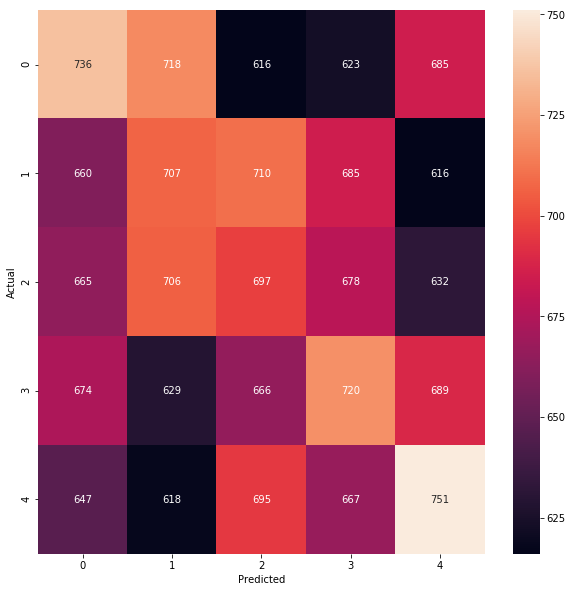

Power_divergenceResult(statistic=array([ 7.12773507, 13.6133807 ,  8.35520095,  7.26534243, 16.90068189]), pvalue=array([0.12929003, 0.00863692, 0.07939985, 0.12251307, 0.00202074]))
[[0.64333925 0.15666075]
 [0.15642392 0.04357608]]
[[ 0.00333925 -0.00333925]
 [-0.00357608  0.00357608]]
Power_divergenceResult(statistic=8.221210775606867, pvalue=0.04165447253192978)
[[0.64185909 0.15814091]
 [0.15814091 0.04185909]]
[[ 0.00185909 -0.00185909]
 [-0.00185909  0.00185909]]
Power_divergenceResult(statistic=2.2802878922439316, pvalue=0.5163077383715216)
[[0.64091178 0.15908822]
 [0.15873298 0.04126702]]
[[ 0.00091178 -0.00091178]
 [-0.00126702  0.00126702]]
Power_divergenceResult(statistic=0.9570196862048549, pvalue=0.8116502984876561)
[[0.64292481 0.15707519]
 [0.15737123 0.04262877]]
[[ 0.00292481 -0.00292481]
 [-0.00262877  0.00262877]]
Power_divergenceResult(statistic=4.776217436352871, pvalue=0.188936392455147)
[[0.64476021 0.15523979]
 [0.15553582 0.04446418]]
[[ 0.00476021 -0.0047602

,Value
start,1970-01-31 00:00:00
end,2016-11-30 00:00:00
cagr,0.0147221
yearly_vol,0.0633497
yearly_sharpe,0.262254
max_drawdown,-0.324603
sortino,0.126035


In [38]:
backtestmodel = BacktestModel(X, Y_class, 
                              model=create_keras_model(3,4,0.01), 
                              coef_dict_param=coef_dict_all, 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean')
backtestmodel.gen_predictions(verbose=False)
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=True, Y=Y)
backtestmodel.gen_returns(calc_returns, verbose=False)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
